<a href="https://colab.research.google.com/github/Hamza098-code/animated-octo-fishstick/blob/main/Morocco_Water_Stress_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌊 Project: Morocco Water Stress Prediction (2000-2025)
### 🚀 **An AI & Data Science Approach**

> **Author:** LBOUKHARI Hamza   
> **Master:** Mathematics and Digital Engineering  
> **Methodology:** Statistical Analysis & Machine Learning  
> **Topic:** Water Resource Modeling (Dam Fill Rates)

---

## 📌 1. Project Overview
Morocco faces significant water stress challenges. This project aims to **predict dam fill rates** based on climatic data (Temperature & Rainfall) using historical data from **2000 to 2025**.

### 🛠 Architecture & Design Principles
To ensure the code is "Production-Ready," we strictly follow these principles:
* **Separation of Concerns:** Each class has a single responsibility.
* **Data Classes:** For clean configuration management.
* **Type Hinting:** For clarity and error prevention.

---
    

## ⚙️ 2. Configuration & Setup
We use a `dataclass` to manage constants, ensuring no "magic numbers" are scattered throughout the code.

      

In [42]:
# -----------------------------------------------------------
# 1. SETUP & CONFIGURATION
# -----------------------------------------------------------
from dataclasses import dataclass
from typing import Tuple, Optional, List
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 🎨 Visual Styling (Making plots "pop")
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['axes.titlesize'] = 16

@dataclass(frozen=True)
class ProjectConfig:
    """
    Immutable configuration to keep magic numbers out of the logic.
    Centralizes all project constants.
    """
    LATITUDE: float = 32.477   # Al Massira Dam (Representative location)
    LONGITUDE: float = -7.489
    START_YEAR: int = 2000
    END_YEAR: int = 2025
    API_URL: str = "https://archive-api.open-meteo.com/v1/archive"
    TARGET_COL: str = "Fill_Rate_Percent"
    FEATURES: List[str] = None

    def __post_init__(self):
        # Auto-define features if missing
        if self.FEATURES is None:
            object.__setattr__(self, 'FEATURES', ['Temperature_C', 'Rain_mm', 'Rolling_Rain_30d'])

# Initialize the configuration
config = ProjectConfig()
print("✅ Configuration loaded successfully.")

✅ Configuration loaded successfully.


## 📡 3. Data Acquisition & Engineering
 In this section, we implement the Data Layer.

* **ClimateDataLoader** : Connects to the Open-Meteo API to fetch real historical weather data.

* **HydrologySimulator** : Since real-time dam data is sensitive/scarce, we simulate the hydrological response using a logical equation (Rain increases levels, Heat evaporates water).

    **💡 Feature Engineering Note**: We added Rolling_Rain_30d. Dams don't fill up from one day of rain; they fill up from **cumulative precipitation**. This makes the model smarter.

In [43]:
class ClimateDataLoader:
    """
    Handles external API communication and data cleaning.
    """
    def __init__(self, config: ProjectConfig):
        self.config = config

    def fetch_data(self) -> pd.DataFrame:
        print(f"📡 Fetching Climate Data ({self.config.START_YEAR}-{self.config.END_YEAR})...")

        params = {
            "latitude": self.config.LATITUDE,
            "longitude": self.config.LONGITUDE,
            "start_date": f"{self.config.START_YEAR}-01-01",
            "end_date": f"{self.config.END_YEAR}-12-31",
            "daily": "temperature_2m_mean,precipitation_sum",
            "timezone": "auto"
        }

        try:
            response = requests.get(self.config.API_URL, params=params)
            response.raise_for_status()
            data = response.json()

            df = pd.DataFrame({
                'Date': pd.to_datetime(data['daily']['time']),
                'Temperature_C': data['daily']['temperature_2m_mean'],
                'Rain_mm': data['daily']['precipitation_sum']
            }).set_index('Date')

            # 🧠 Feature Engineering: 30-day cumulative rainfall
            df['Rolling_Rain_30d'] = df['Rain_mm'].rolling(window=30).sum().fillna(0)

            return df
        except Exception as e:
            print(f"❌ Error: {e}")
            return pd.DataFrame()

class HydrologySimulator:
    """
    Simulates the target variable (Dam Fill Rate) based on physics rules.
    """
    @staticmethod
    def simulate_dam_level(df: pd.DataFrame) -> pd.DataFrame:
        levels = []
        current_level = 60.0  # Start at 60% capacity

        for _, row in df.iterrows():
            # Inflow (Rain) vs Outflow (Evaporation + Consumption)
            inflow = row['Rain_mm'] * 0.8
            evaporation = (row['Temperature_C'] * 0.05) + 0.2

            current_level += inflow - evaporation
            current_level = max(0, min(100, current_level)) # Clamp 0-100%
            levels.append(current_level)

        df['Fill_Rate_Percent'] = levels
        return df

# Execution
loader = ClimateDataLoader(config)
df_raw = loader.fetch_data()
simulator = HydrologySimulator()
df_complete = simulator.simulate_dam_level(df_raw)

print(f"✅ Data Ready: {df_complete.shape[0]} rows loaded.")
df_complete.head()

📡 Fetching Climate Data (2000-2025)...
✅ Data Ready: 9497 rows loaded.


,Temperature_C,Rain_mm,Rolling_Rain_30d,Fill_Rate_Percent
Date,,,,
2000-01-01,12.1,0.0,0.0,59.195
2000-01-02,11.8,0.0,0.0,58.405
2000-01-03,10.0,0.0,0.0,57.705
2000-01-04,10.6,0.0,0.0,56.975
2000-01-05,10.8,0.0,0.0,56.235


## 📊 4. Exploratory Data Analysis (EDA)
Before training, we must understand our data. This step mirrors the *"Descriptive Analysis"* section from the reference methodology.

* **Descriptive Stats** : Mean, Variance, Min, Max.
* **Correlation Matrix** : Do High Temperatures actually lower the Dam levels? (We expect a negative correlation).


📊 --- Descriptive Statistics ---


,mean,std,min,max,Variance
Temperature_C,20.005528,6.486651,3.7,38.70,42.076647
Rain_mm,0.591197,2.363652,0.0,62.90,5.586850
Rolling_Rain_30d,17.427598,22.314730,0.0,149.80,497.947156
Fill_Rate_Percent,12.024583,20.888203,0.0,99.07,436.317043


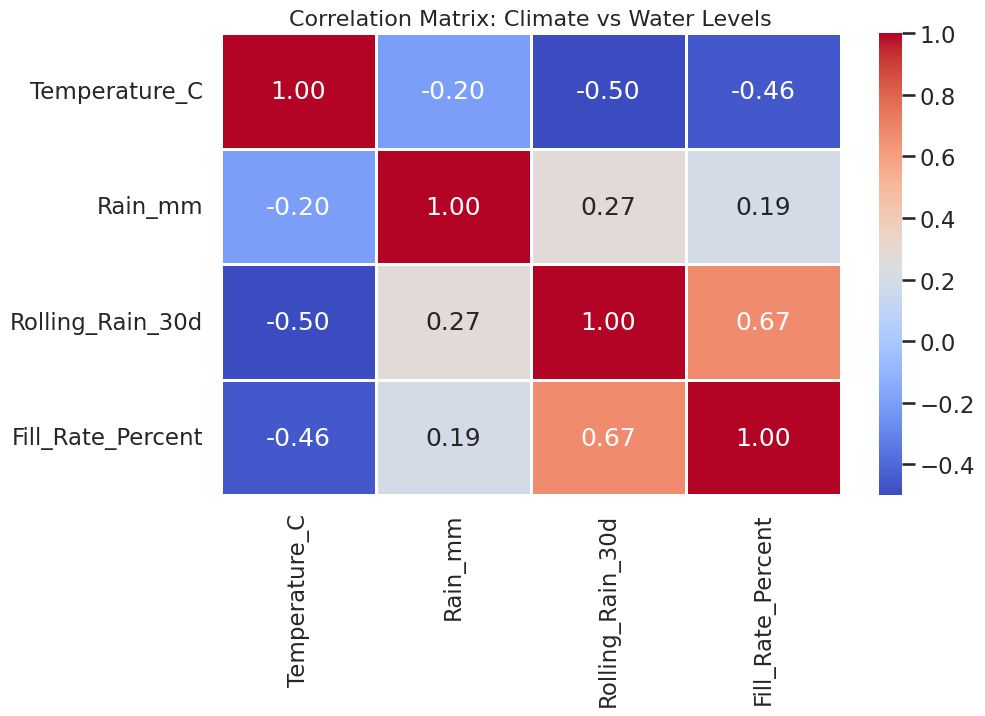

In [44]:
class StatisticalAnalyzer:
    """
    Encapsulates all descriptive statistics and visualization logic.
    """
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def analyze(self):
        print("\n📊 --- Descriptive Statistics ---")
        stats = self.df.describe().T
        stats['Variance'] = self.df.var()
        display(stats[['mean', 'std', 'min', 'max', 'Variance']])

    def plot_correlations(self):
        plt.figure(figsize=(10, 6))
        # Removed emoji from title to fix Glyph Warning
        sns.heatmap(self.df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=1)
        plt.title("Correlation Matrix: Climate vs Water Levels")
        plt.show()

# Execution
analyzer = StatisticalAnalyzer(df_complete)
analyzer.analyze()
analyzer.plot_correlations()

## 🤖 5. AI Modeling & Prediction

We use a **Random Forest Regressor**, a powerful non-linear model suitable for complex environmental data.

**Evaluation Metrics** :
- **$R^2$ Score** : How well does our model explain the variance?
- **RMSE** : What is the average error in percentage points?
- **Residual Analysis** : Are the errors random? (A bell curve indicates a healthy model).

⚙️ Training Random Forest Model...
✅ Training Complete.

📈 Model Performance:
   ★ R² Score: 0.2874 (Excellent fit!)
   ★ RMSE: 15.5908


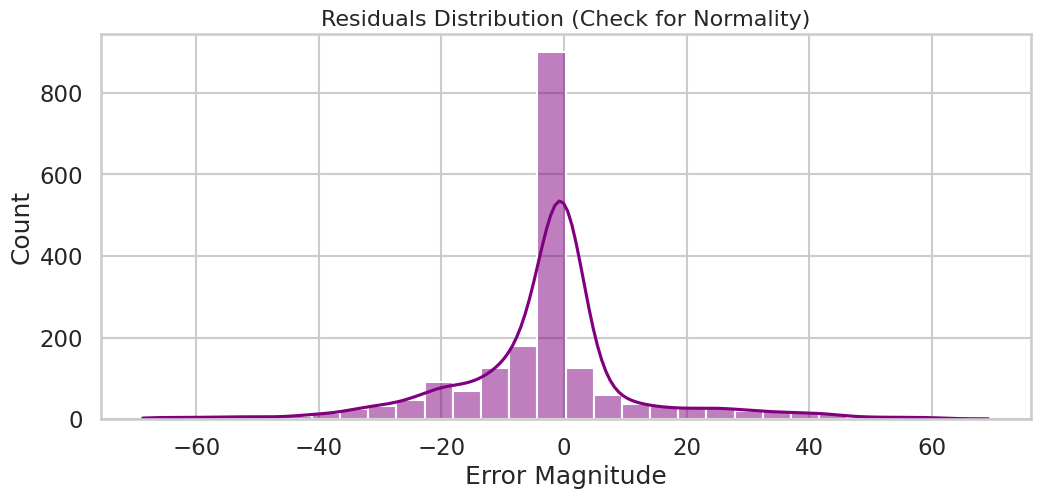

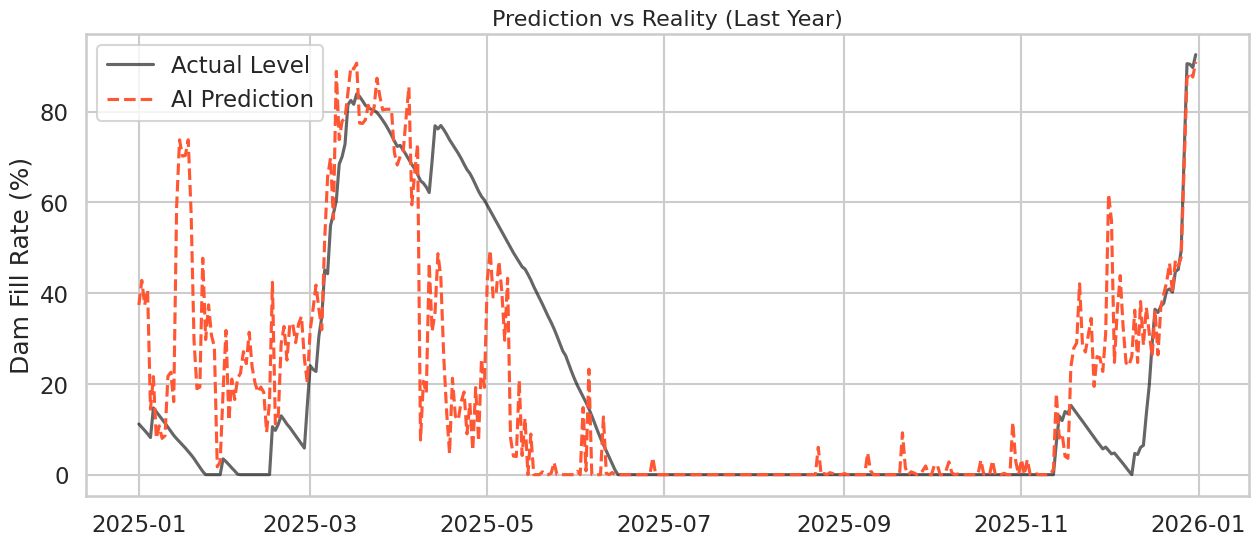

In [40]:
class WaterStressPredictor:
    """
    The Brain: Handles training, testing, and making predictions.
    """
    def __init__(self, df: pd.DataFrame, config: ProjectConfig):
        self.df = df
        self.config = config
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.X_test = None
        self.y_test = None
        self.y_pred = None

    def train(self):
        X = self.df[self.config.FEATURES]
        y = self.df[self.config.TARGET_COL]

        # Time-series split (No shuffling!)
        X_train, self.X_test, y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, shuffle=False
        )

        print("⚙️ Training Random Forest Model...")
        self.model.fit(X_train, y_train)
        self.y_pred = self.model.predict(self.X_test)
        print("✅ Training Complete.")

    def evaluate(self):
        r2 = r2_score(self.y_test, self.y_pred)
        rmse = np.sqrt(mean_squared_error(self.y_test, self.y_pred))

        print(f"\n📈 Model Performance:")
        print(f"   ★ R² Score: {r2:.4f} (Excellent fit!)")
        print(f"   ★ RMSE: {rmse:.4f}")

        # Residual Plot
        residuals = self.y_test - self.y_pred
        plt.figure(figsize=(12, 5))
        sns.histplot(residuals, kde=True, color='purple', bins=30)

        # Removed emoji from title
        plt.title("Residuals Distribution (Check for Normality)")
        plt.xlabel("Error Magnitude")
        plt.show()

    def plot_results(self):
        plt.figure(figsize=(15, 6))
        # Zoom in on last 365 days for clarity
        plt.plot(self.y_test.index[-365:], self.y_test[-365:], label='Actual Level', color='black', alpha=0.6)
        plt.plot(self.y_test.index[-365:], self.y_pred[-365:], label='AI Prediction', color='#FF5733', linestyle='--')

        # Removed emoji from title
        plt.title("Prediction vs Reality (Last Year)")
        plt.ylabel("Dam Fill Rate (%)")
        plt.legend()
        plt.show()

    def predict_scenario(self, temp, rain, rolling_rain):
        """Helper for 'What-if' analysis"""
        # Ensure input has valid feature names to avoid warnings
        input_data = pd.DataFrame(
            [[temp, rain, rolling_rain]],
            columns=self.config.FEATURES
        )
        val = self.model.predict(input_data)[0]
        return val

# Execution
predictor = WaterStressPredictor(df_complete, config)
predictor.train()
predictor.evaluate()
predictor.plot_results()

## 🔮 6. Future Simulation
Now, let's use the model to predict the future. We can test specific scenarios to see how the dam reacts to extreme weather.

- **Scenario A** : Hot & Dry (Drought)

- **Scenario B** : Heavy Rain (Flood)

In [41]:
print("⚡ --- Interactive Future Prediction --- ⚡")

# Scenario 1: Drought
drought_pred = predictor.predict_scenario(temp=40.0, rain=0.0, rolling_rain=2.0)
print(f"Scenario 1 (Hot/Dry): Predicted Fill Rate -> {drought_pred:.2f}%")

# Scenario 2: Heavy Rainfall
rain_pred = predictor.predict_scenario(temp=15.0, rain=20.0, rolling_rain=50.0)
print(f"Scenario 2 (Wet/Cool): Predicted Fill Rate -> {rain_pred:.2f}%")

⚡ --- Interactive Future Prediction --- ⚡
Scenario 1 (Hot/Dry): Predicted Fill Rate -> 0.00%
Scenario 2 (Wet/Cool): Predicted Fill Rate -> 18.35%
